- https://youtu.be/Q_MbN-vu_2w?si=TrCYKV6q64rN6-Fq
- https://youtu.be/qBs29egdVNU?si=9X_UuFSqqsLBNndo
- https://youtu.be/cZ5w3b9ES7Q?si=NaiWh-SkPjqmKlmS

# [자전거 공유 수요](https://www.kaggle.com/competitions/bike-sharing-demand/overview)
워싱턴D.C 소재의 자전거 대여 스타트업의 데이터를 활용하여, 특정 시간대에 얼마나 많은 사람들이 자전거를 대여하는지 예측하는 것이 목표!!

## 평가지표 - RMSLE
- Root Mean Squared Logarithmic Error
- 잔차(residual)에 대한 평균에 로그를 씌운 값
- 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해
- 정답에 대한 오류를 숫자로 나타낸 값이 클 수록 오차가 크다는 의미이다.
  - 즉, 값이 작을 수록 오류가 적다는 의미를 나타낸다.

$$ RMSLE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(y_{i}+1)-log(y\hat{}_{i}+1))^2}$$

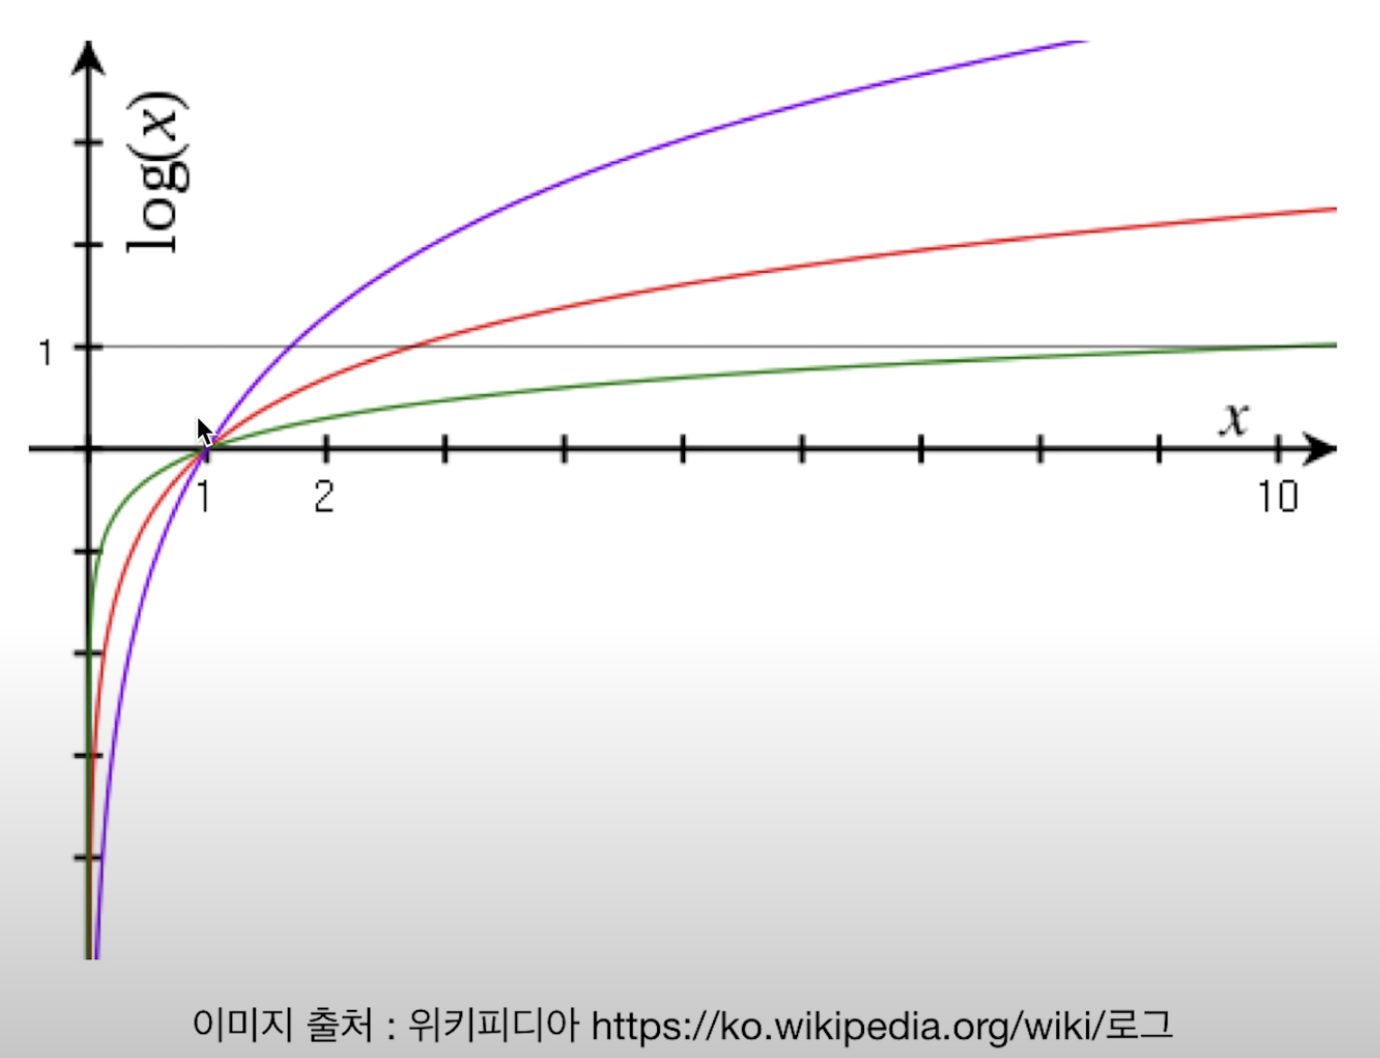

In [1]:
import numpy as np

def rmsle(y, pred, convertExp=False):
    if convertExp:
        y = np.exp(y)
        pred = np.exp(pred)

    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in pred]))
    calc = (log1 - log2)**2

    return np.sqrt(np.mean(calc))

In [2]:
from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## [Data 설명](https://www.kaggle.com/competitions/bike-sharing-demand/data?select=sampleSubmission.csv)

### Features

- datetime:  
  - hourly date + timestamp  
- season(계절):  
  - 1 = spring
  - 2 = summer
  - 3 = fall
  - 4 = winter
- holiday(휴일):  
  - whether the day is considered a holiday
- workingday(근무일):
  - whether the day is neither a weekend nor holiday
- weather(날씨):
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp(온도):
  - temperature in Celsius
- atemp(체감온도):
  - "feels like" temperature in Celsius
- humidity(습도):
  - relative humidity
- windspeed(풍속):
  - wind speed

### Target

- count:
  - 총 대여 수
  - number of total rentals

참고용
- casual:
  - 미등록 사용자 대여 개시 수
  - number of non-registered user rentals initiated
- registered:
  - 등록 사용자 대여 개시
  -  number of registered user rentals initiated

# Import Library

In [3]:
import os
import datetime

# 데이터 분석
import numpy as np
import pandas as pd
from scipy import stats

# 데이터 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')



# 데이터 분리
from sklearn.model_selection import train_test_split


# warning
import warnings
warnings.filterwarnings('ignore')

## Connect to google account

In [4]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


# Global Variables

In [5]:
import easydict
import json
args = easydict.EasyDict()

# path
args.default_path = '/content/data/MyDrive/google_lecture/05. machine learning/Projects/kaggle/bike_sharing_demand/data/'
args.train_path = args.default_path+'train.csv'
args.test_path = args.default_path+'test.csv'

args.submission_path = args.default_path+'sampleSubmission.csv'
args.submission_file = 'Submission_hpo_modeling_{0:.5f}.csv'

args.SEED = 42
args.target_col = 'count'

# Load Data

## train data

In [6]:
ori_train = pd.read_csv(args.train_path)

print(ori_train.shape)
ori_train.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


### target

In [7]:
ori_train['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

## test data

In [8]:
ori_test = pd.read_csv(args.test_path)

print(ori_test.shape)
ori_test.head(3)

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


## 결측치 확인

In [9]:
ori_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [10]:
ori_test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

## 데이터 타입 확인

In [11]:
ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [12]:
ori_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### 데이터 타입 변경

In [13]:
ori_train['datetime'] = pd.to_datetime(ori_train['datetime'])
ori_test['datetime'] = pd.to_datetime(ori_test['datetime'])

In [14]:
ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


## datetime 변수 생성

In [15]:
print(f'before: {ori_train.shape} / {ori_test.shape}')

for data in [ori_train, ori_test]:
  data['year'] = data['datetime'].dt.year # 년도
  data['month'] = data['datetime'].dt.month # 월
  data['day'] = data['datetime'].dt.day # 일
  data['dayofweek'] = data['datetime'].dt.dayofweek # 요일
  data['quarter'] = data['datetime'].dt.quarter # 분기
  data['hour'] = data['datetime'].dt.hour # 시간
  data['minute'] = data['datetime'].dt.minute # 분
  data['second'] = data['datetime'].dt.second # 초

  data['weekend'] = data['dayofweek'].apply(lambda x: int(x in [5,6]))

print(f'after: {ori_train.shape} / {ori_test.shape}')

before: (10886, 12) / (6493, 9)
after: (10886, 21) / (6493, 18)


## 필요없는 컬럼 제거

- test에 없는 컬럼 제외

In [16]:
drop_cols = list(set(ori_train.columns) - set(ori_test.columns))
drop_cols.remove('count') # target 제외
drop_cols

['registered', 'casual']

In [17]:
print(f'before: {ori_train.shape}')
ori_train = ori_train.drop(drop_cols, axis=1)
print(f'after: {ori_train.shape}')

before: (10886, 21)
after: (10886, 19)


In [18]:
drop_cols = ['minute', 'second']
ori_train[drop_cols].describe()

,minute,second
count,10886.0,10886.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [19]:
print(f'before: {ori_train.shape}')
ori_train = ori_train.drop(drop_cols, axis=1)
ori_test = ori_test.drop(drop_cols, axis=1)
print(f'after: {ori_train.shape}')

before: (10886, 19)
after: (10886, 17)


In [20]:
ori_train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,dayofweek,quarter,hour,weekend
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,5,1,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,5,1,1,1


In [21]:
print(f'{ori_train.shape} / {ori_test.shape}')

(10886, 17) / (6493, 16)


# Feature Engineering

## 상관관계

<Axes: >

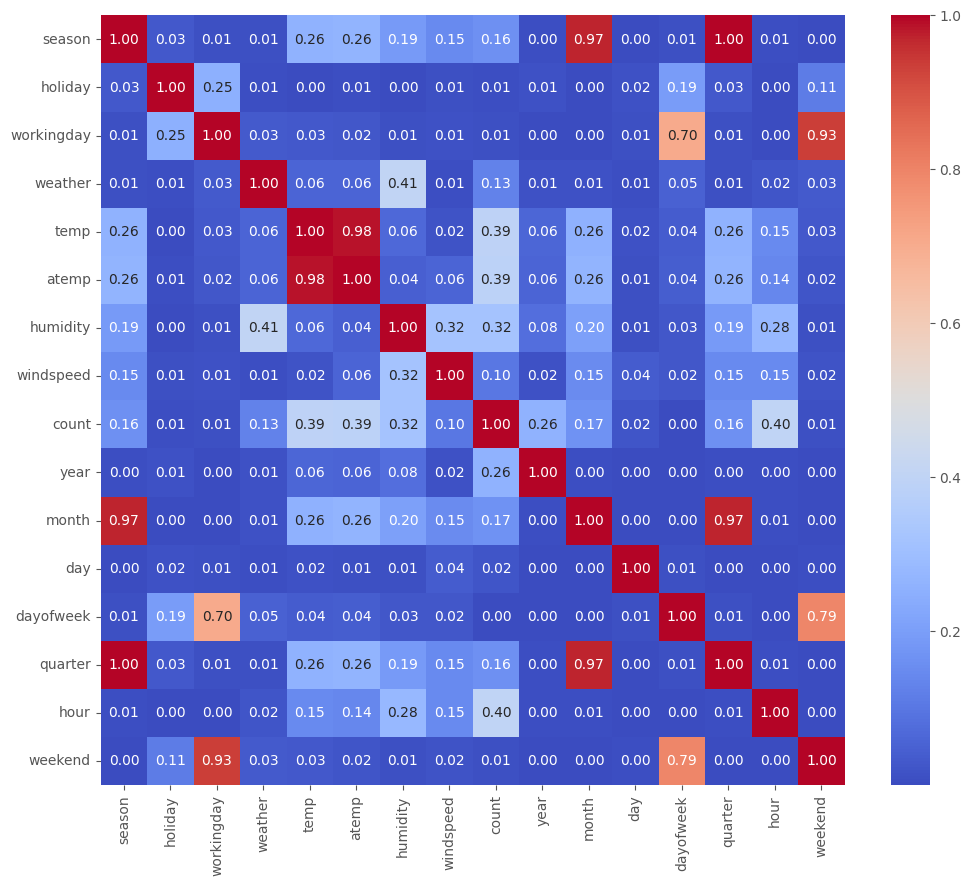

In [22]:
plt.figure(figsize=(12,10))

sns.heatmap(abs(ori_train.corr()), annot=True, fmt=".2f", cmap='coolwarm')

### 다중공선성 처리

In [23]:
from sklearn.decomposition import PCA

- temp, atemp

<Axes: >

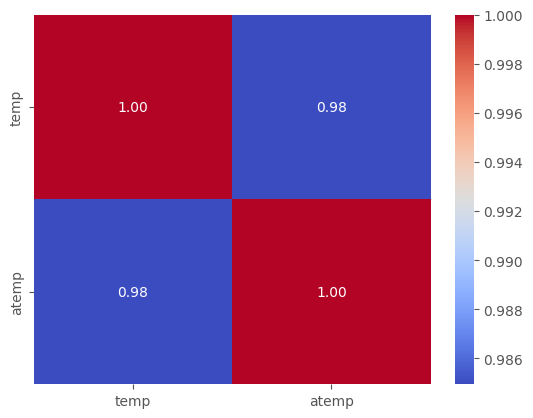

In [24]:
sns.heatmap(abs(ori_train[['temp', 'atemp']].corr()), annot=True, fmt=".2f", cmap='coolwarm')

In [25]:
ori_train[['temp', 'atemp']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    10886 non-null  float64
 1   atemp   10886 non-null  float64
dtypes: float64(2)
memory usage: 170.2 KB


In [26]:
ori_train[['temp', 'atemp']].describe()

,temp,atemp
count,10886.00000,10886.000000
mean,20.23086,23.655084
std,7.79159,8.474601
min,0.82000,0.760000
25%,13.94000,16.665000
50%,20.50000,24.240000
75%,26.24000,31.060000
max,41.00000,45.455000


In [27]:
pca = PCA(n_components=1, random_state=args.SEED)

pca_temp = pca.fit_transform(ori_train[['temp', 'atemp']])
ori_train = ori_train.drop(['temp', 'atemp'], axis=1)
ori_train['pca_temp'] = pca_temp

pca_temp = pca.transform(ori_test[['temp', 'atemp']])
ori_test = ori_test.drop(['temp', 'atemp'], axis=1)
ori_test['pca_temp'] = pca_temp

- month, quarter, season

<Axes: >

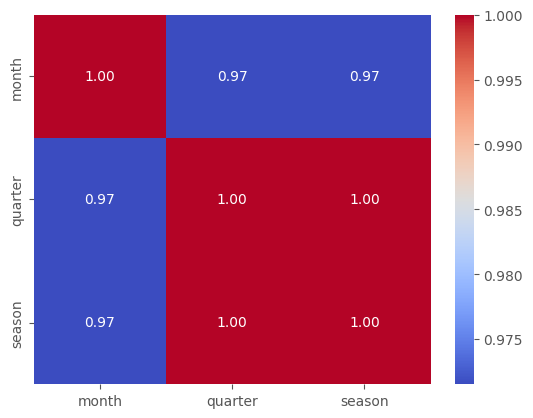

In [28]:
sns.heatmap(abs(ori_train[['month', 'quarter', 'season']].corr()), annot=True, fmt=".2f", cmap='coolwarm')

In [29]:
ori_train[['month', 'quarter', 'season']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   month    10886 non-null  int64
 1   quarter  10886 non-null  int64
 2   season   10886 non-null  int64
dtypes: int64(3)
memory usage: 255.3 KB


In [30]:
ori_train[['month', 'quarter', 'season']].describe()

,month,quarter,season
count,10886.000000,10886.000000,10886.000000
mean,6.521495,2.506614,2.506614
std,3.444373,1.116174,1.116174
min,1.000000,1.000000,1.000000
25%,4.000000,2.000000,2.000000
50%,7.000000,3.000000,3.000000
75%,10.000000,4.000000,4.000000
max,12.000000,4.000000,4.000000


In [32]:
def add_cat_month_quarter_season(row):
    try:
        return str(row['month'])+'_'+str(row['quarter'])+'_'+str(row['season'])
    except:
        return None

In [34]:
ori_train['cat_month_quarter_season'] = ori_train.apply(lambda row: add_cat_month_quarter_season(row), axis=1)
ori_test['cat_month_quarter_season'] = ori_test.apply(lambda row: add_cat_month_quarter_season(row), axis=1)

In [46]:
ori_train['cat_month_quarter_season'].isnull().sum(), ori_test['cat_month_quarter_season'].isnull().sum()

(0, 0)

In [35]:
ori_train.head()

,datetime,season,holiday,workingday,weather,humidity,windspeed,count,year,month,day,dayofweek,quarter,hour,weekend,pca_temp,cat_month_quarter_season
0,2011-01-01 00:00:00,1,0,0,1,81,0.0,16,2011,1,1,5,1,0,1,13.848653,1_1_1
1,2011-01-01 01:00:00,1,0,0,1,80,0.0,40,2011,1,1,5,1,1,1,14.963061,1_1_1
2,2011-01-01 02:00:00,1,0,0,1,80,0.0,32,2011,1,1,5,1,2,1,14.963061,1_1_1
3,2011-01-01 03:00:00,1,0,0,1,75,0.0,13,2011,1,1,5,1,3,1,13.848653,1_1_1
4,2011-01-01 04:00:00,1,0,0,1,75,0.0,1,2011,1,1,5,1,4,1,13.848653,1_1_1


In [36]:
pca = PCA(n_components=1, random_state=args.SEED)

pca_month = pca.fit_transform(ori_train[['month', 'quarter', 'season']])
ori_train = ori_train.drop(['month', 'quarter', 'season'], axis=1)
ori_train['pca_month'] = pca_month

pca_month = pca.transform(ori_test[['month', 'quarter', 'season']])
ori_test = ori_test.drop(['month', 'quarter', 'season'], axis=1)
ori_test['pca_month'] = pca_month

- workingday, dayofweek, weekend

In [39]:
ori_train.columns

Index(['datetime', 'holiday', 'workingday', 'weather', 'humidity', 'windspeed',
       'count', 'year', 'day', 'dayofweek', 'hour', 'weekend', 'pca_temp',
       'cat_month_quarter_season', 'pca_month'],
      dtype='object')

<Axes: >

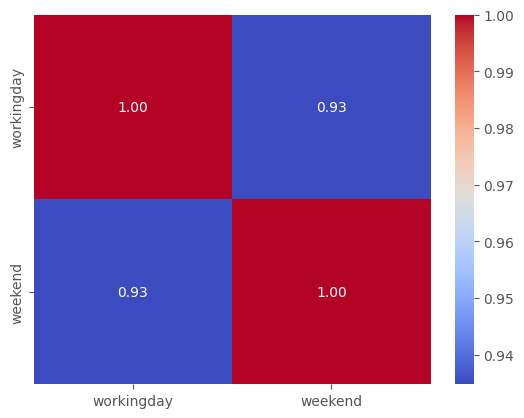

In [43]:
sns.heatmap(abs(ori_train[['workingday', 'weekend']].corr()), annot=True, fmt=".2f", cmap='coolwarm')

In [44]:
ori_train[['workingday', 'weekend']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   workingday  10886 non-null  int64
 1   weekend     10886 non-null  int64
dtypes: int64(2)
memory usage: 170.2 KB


In [45]:
ori_train[['workingday', 'weekend']].describe()

,workingday,weekend
count,10886.000000,10886.000000
mean,0.680875,0.290557
std,0.466159,0.454040
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [47]:
def add_cat_workingday_weekend(row):
    try:
        return str(row['workingday'])+'_'+str(row['weekend'])
    except:
        return None

In [48]:
ori_train['cat_workingday_weekend'] = ori_train.apply(lambda row: add_cat_workingday_weekend(row), axis=1)
ori_test['cat_workingday_weekend'] = ori_test.apply(lambda row: add_cat_workingday_weekend(row), axis=1)

ori_train['cat_workingday_weekend'].isnull().sum(), ori_test['cat_workingday_weekend'].isnull().sum()

(0, 0)

In [49]:
ori_train.head()

,datetime,holiday,workingday,weather,humidity,windspeed,count,year,day,dayofweek,hour,weekend,pca_temp,cat_month_quarter_season,pca_month,cat_workingday_weekend
0,2011-01-01 00:00:00,0,0,1,81,0.0,16,2011,1,5,0,1,13.848653,1_1_1,5.909617,0_1
1,2011-01-01 01:00:00,0,0,1,80,0.0,40,2011,1,5,1,1,14.963061,1_1_1,5.909617,0_1
2,2011-01-01 02:00:00,0,0,1,80,0.0,32,2011,1,5,2,1,14.963061,1_1_1,5.909617,0_1
3,2011-01-01 03:00:00,0,0,1,75,0.0,13,2011,1,5,3,1,13.848653,1_1_1,5.909617,0_1
4,2011-01-01 04:00:00,0,0,1,75,0.0,1,2011,1,5,4,1,13.848653,1_1_1,5.909617,0_1


In [50]:
pca = PCA(n_components=1, random_state=args.SEED)

pca_workingday = pca.fit_transform(ori_train[['workingday', 'weekend']])
ori_train = ori_train.drop(['workingday', 'weekend'], axis=1)
ori_train['pca_workingday'] = pca_workingday

pca_workingday = pca.transform(ori_test[['workingday', 'weekend']])
ori_test = ori_test.drop(['workingday', 'weekend'], axis=1)
ori_test['pca_workingday'] = pca_workingday

### 결과확인

In [53]:
print(f'{ori_train.shape} / {ori_test.shape}')

ori_train.head()

(10886, 15) / (6493, 14)


,datetime,holiday,weather,humidity,windspeed,count,year,day,dayofweek,hour,pca_temp,cat_month_quarter_season,pca_month,cat_workingday_weekend,pca_workingday
0,2011-01-01 00:00:00,0,1,81,0.0,16,2011,1,5,0,13.848653,1_1_1,5.909617,0_1,0.982721
1,2011-01-01 01:00:00,0,1,80,0.0,40,2011,1,5,1,14.963061,1_1_1,5.909617,0_1,0.982721
2,2011-01-01 02:00:00,0,1,80,0.0,32,2011,1,5,2,14.963061,1_1_1,5.909617,0_1,0.982721
3,2011-01-01 03:00:00,0,1,75,0.0,13,2011,1,5,3,13.848653,1_1_1,5.909617,0_1,0.982721
4,2011-01-01 04:00:00,0,1,75,0.0,1,2011,1,5,4,13.848653,1_1_1,5.909617,0_1,0.982721


<Axes: >

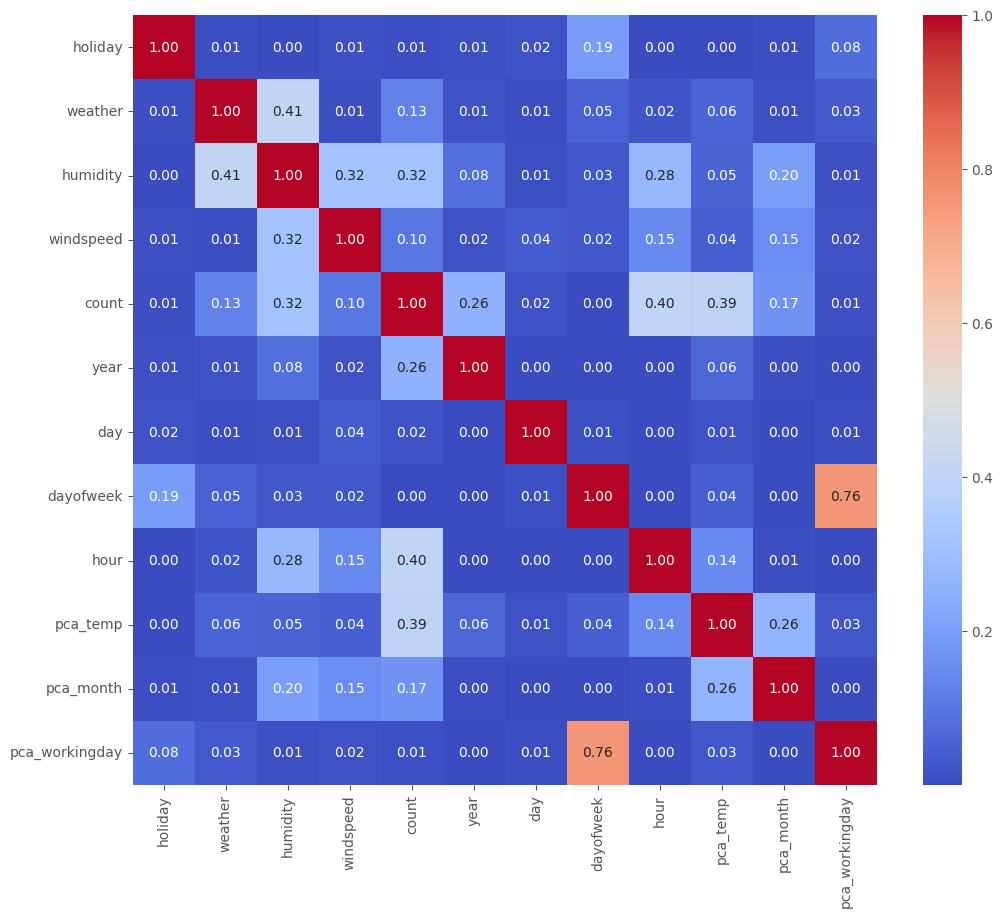

In [51]:
plt.figure(figsize=(12,10))

sns.heatmap(abs(ori_train.corr()), annot=True, fmt=".2f", cmap='coolwarm')